# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  70.19 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 64 #128
N = 20000 #80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 20000
Taking FFT of the images:
Batch 1/10  5.54 sec.
Batch 2/10  5.52 sec.
Batch 3/10  5.54 sec.
Batch 4/10  5.53 sec.
Batch 5/10  5.54 sec.
Batch 6/10  5.54 sec.
Batch 7/10  5.52 sec.
Batch 8/10  5.52 sec.
Batch 9/10  5.54 sec.
Batch 10/10  5.54 sec.
FFT done. Time:  68.28 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (20000, 4096)
Mask radius = 0.0739503816793893
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  10.93 sec.


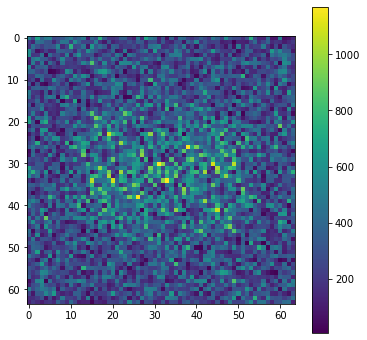

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [7]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different
* SGD seems to overfit at small batch size (e.g. 32) - better objective (??? maybe there's something wrong with how I calculate loss_epoch) but much worse FSC. Batch size = 1000 seems good for both methods, interestingly the OASIS FSC stays above 0.9 for all resolutions (up to 6.6 Angs for nx=128 -> maybe try a bit higher?).

In [274]:
#sigma_noise_est = sigma_noise
#sigma_noise = jnp.ones(sigma_noise.shape)
sigma_noise = sigma_noise_est

In [276]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [277]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [278]:
alpha = 1e-9

slice_obj = Slice(x_grid, mask = mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD and OASIS

In [279]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [281]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [282]:
iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD01z += z * hvp_func1(x0, z, idx)
    zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/iters)
D02 = jnp.array(zD02z/iters)

100%|██████████| 2000/2000 [00:56<00:00, 35.20it/s]


1.0000000000000342e-09
1.6096816576301822e-07
160.9681657630127


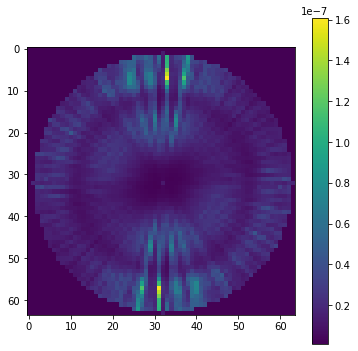

In [283]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

1.0000000000000342e-09
1.6096816576301822e-07


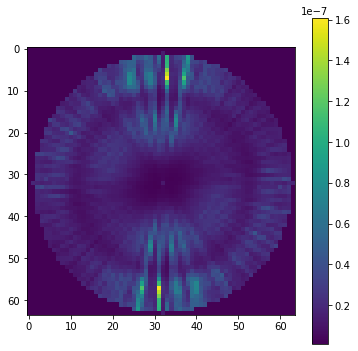

In [284]:
DD = jnp.maximum(jnp.abs(D01), 1e-9)
plt.imshow(jnp.fft.fftshift(jnp.abs(DD[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(DD)))
print(jnp.max(jnp.abs(DD)))

In [285]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02)))
print(jnp.max(jnp.abs(D01-D02)))

1.6096816576301822e-07
1.7291037872478923e-07
1.8303678649075272e-08


#### SGD

In [380]:
N_epochs = 30
batch_size = 1000
step_size = 1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes: 10k imgs, 64px:
#   no sigma_noise, no precon: 1e1
#   no sigma_noise, with precon: 1e-5 I think
#   with sigma_noise, no precon: 1e6
#   with sigma_noise, with precon: 1e-1

In [381]:
#P1 = None
P1 = 1/D01

v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x0, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


Epoch 1/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=2.758e-05, loss=1.478e+03]


  |Grad| = 4.267e-05
  Loss = 1.493e+03
Epoch 2/30 

100%|██████████| 10/10 [00:01<00:00,  6.13it/s, grad=2.923e-05, loss=1.486e+03]


  |Grad| = 2.668e-05
  Loss = 1.483e+03
Epoch 3/30 

100%|██████████| 10/10 [00:01<00:00,  6.07it/s, grad=2.954e-05, loss=1.485e+03]


  |Grad| = 2.723e-05
  Loss = 1.483e+03
Epoch 4/30 

100%|██████████| 10/10 [00:01<00:00,  6.11it/s, grad=2.650e-05, loss=1.486e+03]


  |Grad| = 2.586e-05
  Loss = 1.483e+03
Epoch 5/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=2.565e-05, loss=1.502e+03]


  |Grad| = 2.713e-05
  Loss = 1.483e+03
Epoch 6/30 

100%|██████████| 10/10 [00:01<00:00,  6.17it/s, grad=2.440e-05, loss=1.482e+03]


  |Grad| = 2.630e-05
  Loss = 1.482e+03
Epoch 7/30 

100%|██████████| 10/10 [00:01<00:00,  6.21it/s, grad=2.878e-05, loss=1.496e+03]


  |Grad| = 2.641e-05
  Loss = 1.482e+03
Epoch 8/30 

100%|██████████| 10/10 [00:01<00:00,  6.07it/s, grad=2.728e-05, loss=1.493e+03]


  |Grad| = 2.666e-05
  Loss = 1.482e+03
Epoch 9/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=3.043e-05, loss=1.501e+03]


  |Grad| = 2.670e-05
  Loss = 1.482e+03
Epoch 10/30 

100%|██████████| 10/10 [00:01<00:00,  6.12it/s, grad=2.461e-05, loss=1.481e+03]


  |Grad| = 2.686e-05
  Loss = 1.482e+03
Epoch 11/30 

100%|██████████| 10/10 [00:01<00:00,  6.09it/s, grad=2.742e-05, loss=1.491e+03]


  |Grad| = 2.630e-05
  Loss = 1.482e+03
Epoch 12/30 

100%|██████████| 10/10 [00:01<00:00,  6.10it/s, grad=2.467e-05, loss=1.487e+03]


  |Grad| = 2.773e-05
  Loss = 1.482e+03
Epoch 13/30 

100%|██████████| 10/10 [00:01<00:00,  6.11it/s, grad=2.472e-05, loss=1.477e+03]


  |Grad| = 2.636e-05
  Loss = 1.482e+03
Epoch 14/30 

100%|██████████| 10/10 [00:01<00:00,  6.13it/s, grad=2.498e-05, loss=1.493e+03]


  |Grad| = 2.740e-05
  Loss = 1.482e+03
Epoch 15/30 

100%|██████████| 10/10 [00:01<00:00,  6.14it/s, grad=2.683e-05, loss=1.499e+03]


  |Grad| = 2.719e-05
  Loss = 1.482e+03
Epoch 16/30 

100%|██████████| 10/10 [00:01<00:00,  6.14it/s, grad=2.917e-05, loss=1.495e+03]


  |Grad| = 2.626e-05
  Loss = 1.482e+03
Epoch 17/30 

100%|██████████| 10/10 [00:01<00:00,  6.13it/s, grad=2.952e-05, loss=1.492e+03]


  |Grad| = 2.707e-05
  Loss = 1.482e+03
Epoch 18/30 

100%|██████████| 10/10 [00:01<00:00,  6.13it/s, grad=3.125e-05, loss=1.482e+03]


  |Grad| = 2.730e-05
  Loss = 1.482e+03
Epoch 19/30 

100%|██████████| 10/10 [00:01<00:00,  6.11it/s, grad=3.081e-05, loss=1.477e+03]


  |Grad| = 2.637e-05
  Loss = 1.482e+03
Epoch 20/30 

100%|██████████| 10/10 [00:01<00:00,  6.00it/s, grad=2.497e-05, loss=1.497e+03]


  |Grad| = 2.645e-05
  Loss = 1.482e+03
Epoch 21/30 

100%|██████████| 10/10 [00:01<00:00,  6.04it/s, grad=2.721e-05, loss=1.487e+03]


  |Grad| = 2.645e-05
  Loss = 1.482e+03
Epoch 22/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=2.685e-05, loss=1.488e+03]


  |Grad| = 2.615e-05
  Loss = 1.482e+03
Epoch 23/30 

100%|██████████| 10/10 [00:01<00:00,  5.98it/s, grad=3.100e-05, loss=1.491e+03]


  |Grad| = 2.613e-05
  Loss = 1.482e+03
Epoch 24/30 

100%|██████████| 10/10 [00:01<00:00,  6.03it/s, grad=2.705e-05, loss=1.480e+03]


  |Grad| = 2.615e-05
  Loss = 1.482e+03
Epoch 25/30 

100%|██████████| 10/10 [00:01<00:00,  6.06it/s, grad=2.535e-05, loss=1.481e+03]


  |Grad| = 2.555e-05
  Loss = 1.482e+03
Epoch 26/30 

100%|██████████| 10/10 [00:01<00:00,  6.08it/s, grad=2.599e-05, loss=1.490e+03]


  |Grad| = 2.639e-05
  Loss = 1.482e+03
Epoch 27/30 

100%|██████████| 10/10 [00:01<00:00,  6.15it/s, grad=2.807e-05, loss=1.492e+03]


  |Grad| = 2.581e-05
  Loss = 1.482e+03
Epoch 28/30 

100%|██████████| 10/10 [00:01<00:00,  6.10it/s, grad=2.564e-05, loss=1.470e+03]


  |Grad| = 2.620e-05
  Loss = 1.482e+03
Epoch 29/30 

100%|██████████| 10/10 [00:01<00:00,  6.09it/s, grad=2.584e-05, loss=1.483e+03]


  |Grad| = 2.598e-05
  Loss = 1.482e+03
Epoch 30/30 

100%|██████████| 10/10 [00:01<00:00,  6.05it/s, grad=2.594e-05, loss=1.485e+03]

  |Grad| = 2.617e-05
  Loss = 1.482e+03


In [382]:
#P2 = None
P2 = 1/D02

v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x0, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


Epoch 1/30 

100%|██████████| 10/10 [00:01<00:00,  6.25it/s, grad=3.593e-05, loss=1.464e+03]


  |Grad| = 4.349e-05
  Loss = 1.491e+03
Epoch 2/30 

100%|██████████| 10/10 [00:01<00:00,  6.28it/s, grad=2.880e-05, loss=1.474e+03]


  |Grad| = 2.667e-05
  Loss = 1.482e+03
Epoch 3/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=3.151e-05, loss=1.480e+03]


  |Grad| = 2.751e-05
  Loss = 1.481e+03
Epoch 4/30 

100%|██████████| 10/10 [00:01<00:00,  6.29it/s, grad=2.707e-05, loss=1.483e+03]


  |Grad| = 2.721e-05
  Loss = 1.481e+03
Epoch 5/30 

100%|██████████| 10/10 [00:01<00:00,  6.34it/s, grad=2.437e-05, loss=1.475e+03]


  |Grad| = 2.623e-05
  Loss = 1.481e+03
Epoch 6/30 

100%|██████████| 10/10 [00:01<00:00,  6.32it/s, grad=2.522e-05, loss=1.487e+03]


  |Grad| = 2.631e-05
  Loss = 1.481e+03
Epoch 7/30 

100%|██████████| 10/10 [00:01<00:00,  6.33it/s, grad=3.068e-05, loss=1.484e+03]


  |Grad| = 2.727e-05
  Loss = 1.481e+03
Epoch 8/30 

100%|██████████| 10/10 [00:01<00:00,  6.26it/s, grad=2.653e-05, loss=1.474e+03]


  |Grad| = 2.582e-05
  Loss = 1.481e+03
Epoch 9/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=2.986e-05, loss=1.486e+03]


  |Grad| = 2.703e-05
  Loss = 1.481e+03
Epoch 10/30 

100%|██████████| 10/10 [00:01<00:00,  6.28it/s, grad=3.244e-05, loss=1.483e+03]


  |Grad| = 2.738e-05
  Loss = 1.481e+03
Epoch 11/30 

100%|██████████| 10/10 [00:01<00:00,  6.36it/s, grad=2.621e-05, loss=1.480e+03]


  |Grad| = 2.676e-05
  Loss = 1.481e+03
Epoch 12/30 

100%|██████████| 10/10 [00:01<00:00,  6.30it/s, grad=2.897e-05, loss=1.479e+03]


  |Grad| = 2.698e-05
  Loss = 1.481e+03
Epoch 13/30 

100%|██████████| 10/10 [00:01<00:00,  6.30it/s, grad=2.790e-05, loss=1.488e+03]


  |Grad| = 2.593e-05
  Loss = 1.481e+03
Epoch 14/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=2.614e-05, loss=1.475e+03]


  |Grad| = 2.601e-05
  Loss = 1.481e+03
Epoch 15/30 

100%|██████████| 10/10 [00:01<00:00,  6.19it/s, grad=2.680e-05, loss=1.487e+03]


  |Grad| = 2.558e-05
  Loss = 1.481e+03
Epoch 16/30 

100%|██████████| 10/10 [00:01<00:00,  6.23it/s, grad=2.406e-05, loss=1.484e+03]


  |Grad| = 2.654e-05
  Loss = 1.481e+03
Epoch 17/30 

100%|██████████| 10/10 [00:01<00:00,  6.29it/s, grad=2.711e-05, loss=1.478e+03]


  |Grad| = 2.685e-05
  Loss = 1.481e+03
Epoch 18/30 

100%|██████████| 10/10 [00:01<00:00,  6.28it/s, grad=2.618e-05, loss=1.479e+03]


  |Grad| = 2.650e-05
  Loss = 1.481e+03
Epoch 19/30 

100%|██████████| 10/10 [00:01<00:00,  6.27it/s, grad=2.485e-05, loss=1.482e+03]


  |Grad| = 2.663e-05
  Loss = 1.481e+03
Epoch 20/30 

100%|██████████| 10/10 [00:01<00:00,  6.30it/s, grad=2.364e-05, loss=1.482e+03]


  |Grad| = 2.718e-05
  Loss = 1.481e+03
Epoch 21/30 

100%|██████████| 10/10 [00:01<00:00,  6.32it/s, grad=2.789e-05, loss=1.467e+03]


  |Grad| = 2.728e-05
  Loss = 1.481e+03
Epoch 22/30 

100%|██████████| 10/10 [00:01<00:00,  6.34it/s, grad=2.726e-05, loss=1.483e+03]


  |Grad| = 2.731e-05
  Loss = 1.481e+03
Epoch 23/30 

100%|██████████| 10/10 [00:01<00:00,  6.30it/s, grad=2.444e-05, loss=1.469e+03]


  |Grad| = 2.679e-05
  Loss = 1.481e+03
Epoch 24/30 

100%|██████████| 10/10 [00:01<00:00,  6.33it/s, grad=2.212e-05, loss=1.476e+03]


  |Grad| = 2.644e-05
  Loss = 1.481e+03
Epoch 25/30 

100%|██████████| 10/10 [00:01<00:00,  6.39it/s, grad=2.943e-05, loss=1.481e+03]


  |Grad| = 2.662e-05
  Loss = 1.481e+03
Epoch 26/30 

100%|██████████| 10/10 [00:01<00:00,  6.26it/s, grad=2.499e-05, loss=1.484e+03]


  |Grad| = 2.631e-05
  Loss = 1.481e+03
Epoch 27/30 

100%|██████████| 10/10 [00:01<00:00,  6.35it/s, grad=2.652e-05, loss=1.482e+03]


  |Grad| = 2.832e-05
  Loss = 1.481e+03
Epoch 28/30 

100%|██████████| 10/10 [00:01<00:00,  6.29it/s, grad=2.561e-05, loss=1.477e+03]


  |Grad| = 2.507e-05
  Loss = 1.481e+03
Epoch 29/30 

100%|██████████| 10/10 [00:01<00:00,  6.32it/s, grad=2.531e-05, loss=1.489e+03]


  |Grad| = 2.604e-05
  Loss = 1.481e+03
Epoch 30/30 

100%|██████████| 10/10 [00:01<00:00,  6.29it/s, grad=2.820e-05, loss=1.480e+03]

  |Grad| = 2.656e-05
  Loss = 1.481e+03


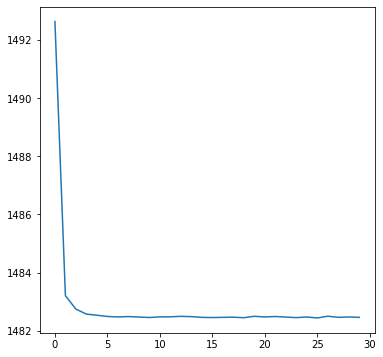

In [383]:
plt.plot(loss_rec1)

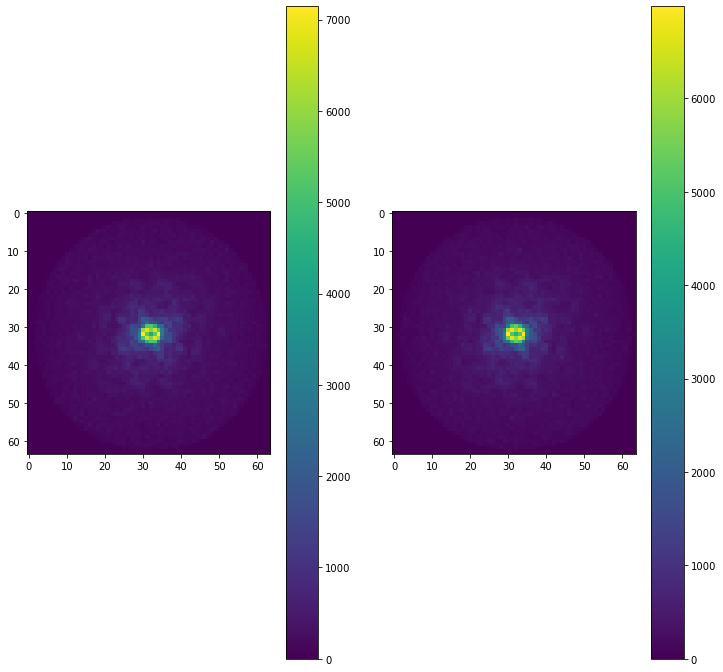

In [384]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); plt.colorbar()

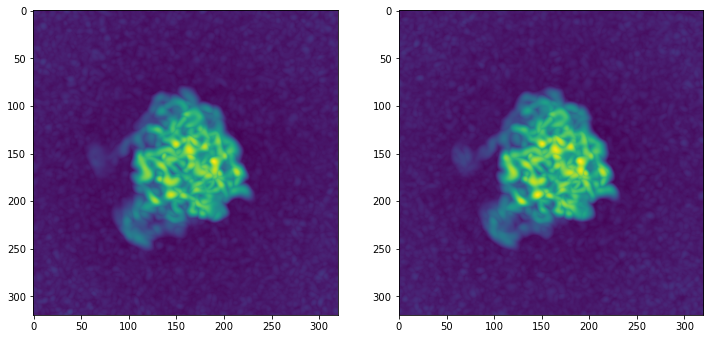

In [385]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [386]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

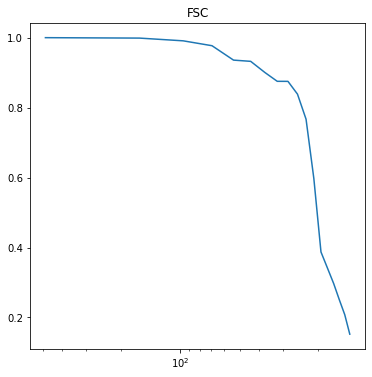

In [389]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [390]:
print(fsc_sgd[11])
print(fsc_sgd[12])
print(res_angs[11])
print(res_angs[12])

0.5973729473829412
0.3872872508602027
21.04567242124271
19.362018627543293


#### OASIS

#### Some notes:

* OASIS rec with fixed rate should is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning). 
* Work with a dataset with no heterogeneity
* Still don't know why the adaptive version fails

In [334]:
N_epoch = 30
beta2 = 1 #0.99
eta0 = 1e-4 #1e-4 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-16 #0.1 # 0.01

D0bad = jnp.array(np.random.randn(*D01.shape))

key, subkey = random.split(key)


# Step sizes (eta0): 10k imgs, 64px:
#   no sigma_noise 1e-5 
#   with sigma_noise: 1e-4

In [335]:

v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/30


100%|██████████| 10/10 [00:02<00:00,  3.82it/s, loss=1.564e+03]


  Loss =  1.560e+03
Epoch 2/30


100%|██████████| 10/10 [00:02<00:00,  3.84it/s, loss=1.554e+03]


  Loss =  1.559e+03
Epoch 3/30


100%|██████████| 10/10 [00:02<00:00,  3.79it/s, loss=1.568e+03]


  Loss =  1.559e+03
Epoch 4/30


100%|██████████| 10/10 [00:02<00:00,  3.81it/s, loss=1.557e+03]


  Loss =  1.559e+03
Epoch 5/30


100%|██████████| 10/10 [00:02<00:00,  3.81it/s, loss=1.563e+03]


  Loss =  1.559e+03
Epoch 6/30


100%|██████████| 10/10 [00:02<00:00,  3.84it/s, loss=1.570e+03]


  Loss =  1.559e+03
Epoch 7/30


100%|██████████| 10/10 [00:02<00:00,  3.80it/s, loss=1.552e+03]


  Loss =  1.559e+03
Epoch 8/30


100%|██████████| 10/10 [00:02<00:00,  3.80it/s, loss=1.557e+03]


  Loss =  1.559e+03
Epoch 9/30


100%|██████████| 10/10 [00:02<00:00,  3.82it/s, loss=1.577e+03]


  Loss =  1.559e+03
Epoch 10/30


100%|██████████| 10/10 [00:02<00:00,  3.79it/s, loss=1.567e+03]


  Loss =  1.559e+03
Epoch 11/30


100%|██████████| 10/10 [00:02<00:00,  3.81it/s, loss=1.559e+03]


  Loss =  1.559e+03
Epoch 12/30


100%|██████████| 10/10 [00:02<00:00,  3.77it/s, loss=1.546e+03]


  Loss =  1.559e+03
Epoch 13/30


100%|██████████| 10/10 [00:02<00:00,  3.81it/s, loss=1.570e+03]


  Loss =  1.559e+03
Epoch 14/30


100%|██████████| 10/10 [00:02<00:00,  3.81it/s, loss=1.548e+03]


  Loss =  1.559e+03
Epoch 15/30


100%|██████████| 10/10 [00:02<00:00,  3.75it/s, loss=1.565e+03]


  Loss =  1.559e+03
Epoch 16/30


100%|██████████| 10/10 [00:02<00:00,  3.78it/s, loss=1.564e+03]


  Loss =  1.559e+03
Epoch 17/30


100%|██████████| 10/10 [00:02<00:00,  3.74it/s, loss=1.560e+03]


  Loss =  1.559e+03
Epoch 18/30


100%|██████████| 10/10 [00:02<00:00,  3.74it/s, loss=1.558e+03]


  Loss =  1.559e+03
Epoch 19/30


100%|██████████| 10/10 [00:02<00:00,  3.79it/s, loss=1.561e+03]


  Loss =  1.559e+03
Epoch 20/30


100%|██████████| 10/10 [00:02<00:00,  3.79it/s, loss=1.541e+03]


  Loss =  1.559e+03
Epoch 21/30


100%|██████████| 10/10 [00:02<00:00,  3.77it/s, loss=1.550e+03]


  Loss =  1.559e+03
Epoch 22/30


100%|██████████| 10/10 [00:02<00:00,  3.74it/s, loss=1.551e+03]


  Loss =  1.559e+03
Epoch 23/30


100%|██████████| 10/10 [00:02<00:00,  3.76it/s, loss=1.559e+03]


  Loss =  1.559e+03
Epoch 24/30


100%|██████████| 10/10 [00:02<00:00,  3.83it/s, loss=1.551e+03]


  Loss =  1.559e+03
Epoch 25/30


100%|██████████| 10/10 [00:02<00:00,  3.78it/s, loss=1.540e+03]


  Loss =  1.559e+03
Epoch 26/30


100%|██████████| 10/10 [00:02<00:00,  3.77it/s, loss=1.558e+03]


  Loss =  1.559e+03
Epoch 27/30


100%|██████████| 10/10 [00:02<00:00,  3.75it/s, loss=1.561e+03]


  Loss =  1.559e+03
Epoch 28/30


100%|██████████| 10/10 [00:02<00:00,  3.76it/s, loss=1.550e+03]


  Loss =  1.559e+03
Epoch 29/30


100%|██████████| 10/10 [00:02<00:00,  3.79it/s, loss=1.560e+03]


  Loss =  1.559e+03
Epoch 30/30


100%|██████████| 10/10 [00:02<00:00,  3.78it/s, loss=1.546e+03]

  Loss =  1.559e+03


In [336]:
#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [337]:
v_rec_o2, loss_o2 = oasis(subkey, loss_func2, grad_func2, hvp_func2, x0, eta0, D02, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/30


100%|██████████| 10/10 [00:02<00:00,  3.90it/s, loss=1.552e+03]


  Loss =  1.559e+03
Epoch 2/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=1.564e+03]


  Loss =  1.559e+03
Epoch 3/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=1.565e+03]


  Loss =  1.559e+03
Epoch 4/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=1.553e+03]


  Loss =  1.558e+03
Epoch 5/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=1.551e+03]


  Loss =  1.558e+03
Epoch 6/30


100%|██████████| 10/10 [00:02<00:00,  3.91it/s, loss=1.539e+03]


  Loss =  1.558e+03
Epoch 7/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=1.555e+03]


  Loss =  1.558e+03
Epoch 8/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=1.561e+03]


  Loss =  1.558e+03
Epoch 9/30


100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=1.559e+03]


  Loss =  1.558e+03
Epoch 10/30


100%|██████████| 10/10 [00:02<00:00,  4.01it/s, loss=1.546e+03]


  Loss =  1.558e+03
Epoch 11/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=1.550e+03]


  Loss =  1.558e+03
Epoch 12/30


100%|██████████| 10/10 [00:02<00:00,  4.02it/s, loss=1.557e+03]


  Loss =  1.558e+03
Epoch 13/30


100%|██████████| 10/10 [00:02<00:00,  4.01it/s, loss=1.562e+03]


  Loss =  1.558e+03
Epoch 14/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=1.562e+03]


  Loss =  1.558e+03
Epoch 15/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=1.564e+03]


  Loss =  1.558e+03
Epoch 16/30


100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=1.554e+03]


  Loss =  1.558e+03
Epoch 17/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=1.547e+03]


  Loss =  1.558e+03
Epoch 18/30


100%|██████████| 10/10 [00:02<00:00,  4.01it/s, loss=1.564e+03]


  Loss =  1.558e+03
Epoch 19/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=1.556e+03]


  Loss =  1.558e+03
Epoch 20/30


100%|██████████| 10/10 [00:02<00:00,  3.95it/s, loss=1.564e+03]


  Loss =  1.558e+03
Epoch 21/30


100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=1.552e+03]


  Loss =  1.558e+03
Epoch 22/30


100%|██████████| 10/10 [00:02<00:00,  4.02it/s, loss=1.549e+03]


  Loss =  1.558e+03
Epoch 23/30


100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=1.557e+03]


  Loss =  1.558e+03
Epoch 24/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=1.558e+03]


  Loss =  1.558e+03
Epoch 25/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=1.552e+03]


  Loss =  1.558e+03
Epoch 26/30


100%|██████████| 10/10 [00:02<00:00,  3.96it/s, loss=1.552e+03]


  Loss =  1.558e+03
Epoch 27/30


100%|██████████| 10/10 [00:02<00:00,  3.94it/s, loss=1.562e+03]


  Loss =  1.558e+03
Epoch 28/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=1.552e+03]


  Loss =  1.558e+03
Epoch 29/30


100%|██████████| 10/10 [00:02<00:00,  4.00it/s, loss=1.558e+03]


  Loss =  1.558e+03
Epoch 30/30


100%|██████████| 10/10 [00:02<00:00,  3.97it/s, loss=1.547e+03]

  Loss =  1.558e+03


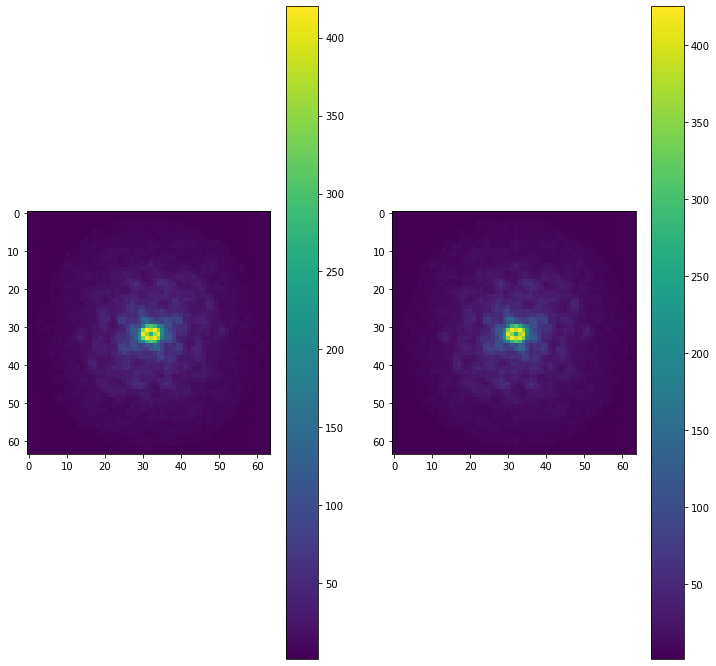

In [338]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2))); plt.colorbar()

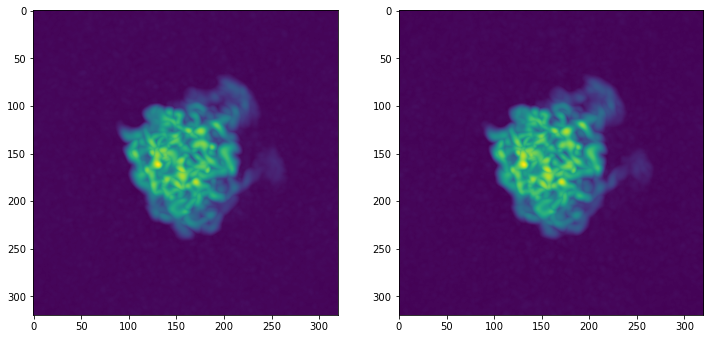

In [339]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [340]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

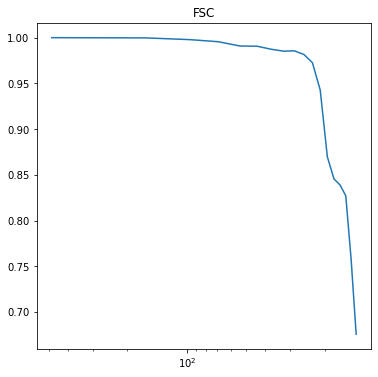

In [341]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

In [342]:
print(fsc_o[11])
print(fsc_o[12])
print(res_angs[11])
print(res_angs[12])

0.9427512149829093
0.8697761225277715
21.04567242124271
19.362018627543293


In [343]:
Nn = N//2

In [344]:
loss_func1(v_rec1, jnp.arange(Nn))

DeviceArray(1489.17565281, dtype=float64)

In [345]:
loss_func2(v_rec2, jnp.arange(Nn))

DeviceArray(1487.57884506, dtype=float64)

In [346]:
loss_func1(v_rec_o1, jnp.arange(Nn))

DeviceArray(1558.77828452, dtype=float64)

In [347]:
loss_func2(v_rec_o2, jnp.arange(Nn))

DeviceArray(1557.89112636, dtype=float64)

#### Now the same with CG

In [348]:
N_iter = 300


In [349]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


In [350]:

v_rec_cg1, _ = cg(AA1, Ab1, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 0.0015311920825547948
  cg iter 10 ||r|| = 0.0027803053540307507
  cg iter 20 ||r|| = 0.002334412359239641
  cg iter 30 ||r|| = 0.0018994531402005432
  cg iter 40 ||r|| = 0.001640788595086421
  cg iter 50 ||r|| = 0.0014267836892368252
  cg iter 60 ||r|| = 0.0013335887145107157
  cg iter 70 ||r|| = 0.0011861506435619255
  cg iter 80 ||r|| = 0.0010755832125466807
  cg iter 90 ||r|| = 0.0010300911448796613
  cg iter 100 ||r|| = 0.001002453471084205
  cg iter 110 ||r|| = 0.0009264377560122893
  cg iter 120 ||r|| = 0.0008880402975742234
  cg iter 130 ||r|| = 0.0008665899100273343
  cg iter 140 ||r|| = 0.0008740239624841839
  cg iter 150 ||r|| = 0.0008253457550488647
  cg iter 160 ||r|| = 0.0007772394876046772
  cg iter 170 ||r|| = 0.0008269124667390462
  cg iter 180 ||r|| = 0.0008007612084966351
  cg iter 190 ||r|| = 0.000674229516534921
  cg iter 200 ||r|| = 0.0006538950573513877
  cg iter 210 ||r|| = 0.000753738089192548
  cg iter 220 ||r|| = 0.0007377568066741264
  cg

In [351]:
v_rec_cg2, _ = cg(AA2, Ab2, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 0.001537164437486776
  cg iter 10 ||r|| = 0.0027982945559299477
  cg iter 20 ||r|| = 0.002410954613305618
  cg iter 30 ||r|| = 0.001911024369186041
  cg iter 40 ||r|| = 0.001686722639679866
  cg iter 50 ||r|| = 0.0014496141796262922
  cg iter 60 ||r|| = 0.0013183238139609648
  cg iter 70 ||r|| = 0.0012203903615154179
  cg iter 80 ||r|| = 0.0011249085178378529
  cg iter 90 ||r|| = 0.0010860133386974826
  cg iter 100 ||r|| = 0.0010441032772697954
  cg iter 110 ||r|| = 0.0009623017132428765
  cg iter 120 ||r|| = 0.000907653475948826
  cg iter 130 ||r|| = 0.0008828458294863383
  cg iter 140 ||r|| = 0.0008160723082971552
  cg iter 150 ||r|| = 0.0008715401782097358
  cg iter 160 ||r|| = 0.0008208589487389777
  cg iter 170 ||r|| = 0.0006892691704822342
  cg iter 180 ||r|| = 0.0007997420863657776
  cg iter 190 ||r|| = 0.0006637488823599181
  cg iter 200 ||r|| = 0.0008010638807184716
  cg iter 210 ||r|| = 0.0007492696332420205
  cg iter 220 ||r|| = 0.0006670291653889833
  cg

In [352]:
Nn=N//2

In [353]:
loss_func1(v_rec_cg1, jnp.arange(Nn))

DeviceArray(165716.16691706, dtype=float64)

In [354]:
loss_func2(v_rec_cg2, jnp.arange(Nn))

DeviceArray(164595.00210176, dtype=float64)

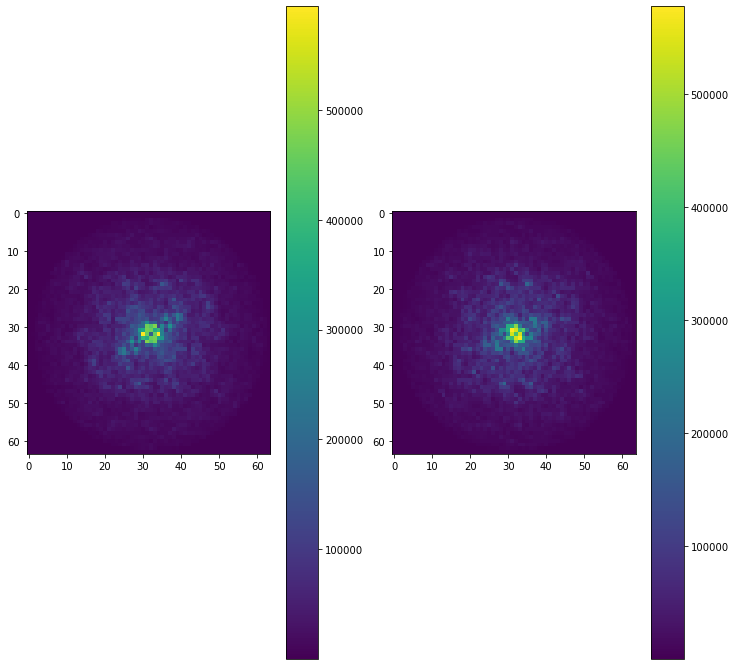

In [355]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

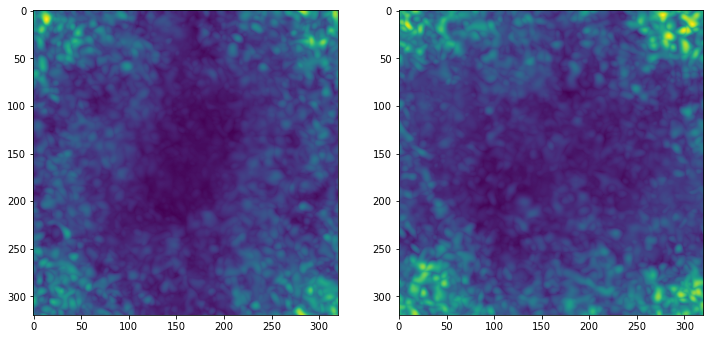

In [356]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [357]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

Text(0.5, 1.0, 'FSC')

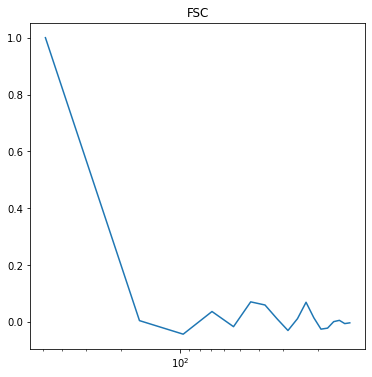

In [358]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

Text(0.5, 1.0, 'FSC')

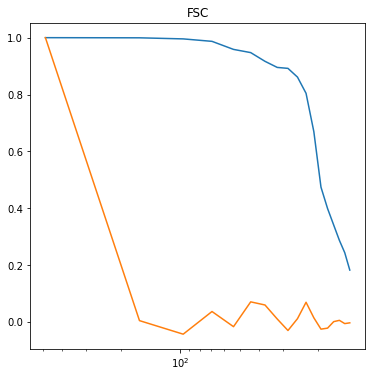

In [359]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [360]:
print(fsc_cg[11])
print(fsc_cg[12])
print(res_angs[11])
print(res_angs[12])

0.014967565440190357
-0.024969167661544923
21.04567242124271
19.362018627543293


#### Some conclusions:

##### Running nx_crop=64px and 10,000 images in each half set:
without $\sigma_{noise}$:
* FSC SGD is above 0.94 all the way when using the correct preconditioner (30 epochs). Without preconditioner, it is almost the same as CG (with the appropriate learning rate) - FSC=0.5 at around 20 Angs
* FSC OASIS is almost identical to SGD with precon, the FSC is almost the same (30 epochs)
* CG 300 iters i.e. epochs, FSC=0.5 at 20 Angs

with $\sigma_{noise}$:

* FSC SGD no precon 20 Angs for FSC=0.5
* FSC SGD with precon still 20 Angs at FSC=0.5
* FSC OASIS above 0.65 all the way
* FSC CG: crap

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [ ]:
f(x0)

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
plt.plot(loss_n)

In [ ]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

In [ ]:
F(x_cg)

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 10000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* Run on CryoEM data